# Video Classification For Human Activity Recognition With  Two Stream Approach[Temporal(RGB) + Spatial(Optical Flow)]

## Import Libraries

In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


## Visualize the Data with its Labels

In this step, we will visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors.


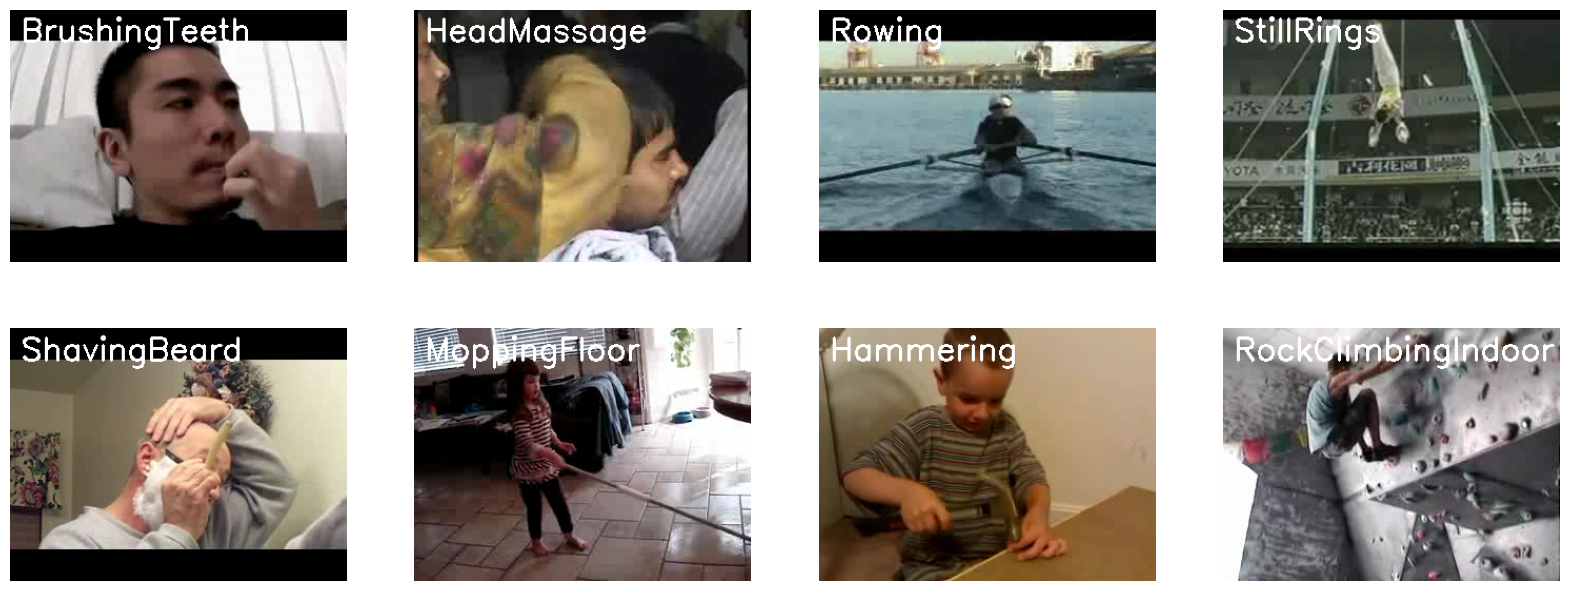

In [28]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('Dataset/UCF-101')

# Generate a list of 8 random values. The values will be between 0-101, 
# where 101 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 8)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/UCF-101/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/UCF-101/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## Preprocess the Dataset

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height.

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 60, 60

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "dataset/UCF-101"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling"]

In [5]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them, and compute optical flow between consecutive frames.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        rgb_frames_list: A list containing the resized and normalized RGB frames of the video.
        flow_frames_list: A list containing the resized and normalized optical flow frames of the video.
    '''

    # Declare a list to store video frames.
    rgb_frames_list = []
    flow_frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Read the first frame
    success, previous_frame = video_reader.read()
    if not success:
        print("Error: Could not read the first frame")
        return rgb_frames_list, flow_frames_list
    
    # Convert to grayscale for optical flow
    previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, current_frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
            
        # Convert to grayscale for optical flow
        current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow between the previous frame and the current frame
        flow = cv2.calcOpticalFlowFarneback(previous_frame_gray, current_frame_gray, None, 
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        
        # Normalize the optical flow
        flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flow_magnitude = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        flow_magnitude = np.uint8(flow_magnitude)
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(current_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        resized_flow = cv2.resize(flow_magnitude, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        normalized_flow = resized_flow / 255.0
        
        # Append the normalized frame into the frames list
        rgb_frames_list.append(normalized_frame)
        flow_frames_list.append(normalized_flow)

        # Set the current frame to the previous frame for the next iteration
        previous_frame_gray = current_frame_gray

    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return rgb_frames_list, flow_frames_list

Create a function to save frames inside folders

In [6]:
def save_frames(class_name, video_name, rgb_frames, flow_frames):
    '''
    This function saves the RGB and optical flow frames to their respective class directories.
    Args:
        class_name: Name of the class to which the frames belong.
        video_name: Name of the video file being processed.
        rgb_frames: List of RGB frames.
        flow_frames: List of optical flow frames.
    '''
    # Create directories for RGB and optical flow frames if they don't exist.
    rgb_output_dir = os.path.join('processed_frames', 'rgb', class_name, video_name)
    flow_output_dir = os.path.join('processed_frames', 'flow', class_name, video_name)
    os.makedirs(rgb_output_dir, exist_ok=True)
    os.makedirs(flow_output_dir, exist_ok=True)

    # Save each frame as an image file.
    for i, (rgb_frame, flow_frame) in enumerate(zip(rgb_frames, flow_frames)):
        rgb_frame_path = os.path.join(rgb_output_dir, f'frame_{i+1:04d}.jpg')
        flow_frame_path = os.path.join(flow_output_dir, f'frame_{i+1:04d}.jpg')
        cv2.imwrite(rgb_frame_path, (rgb_frame * 255).astype(np.uint8))
        cv2.imwrite(flow_frame_path, (flow_frame * 255).astype(np.uint8))


### Create a Function for Dataset Creation

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes.

In [7]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    rgb_features = []
    flow_features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            rgb_frames, flow_frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(rgb_frames) == SEQUENCE_LENGTH and len(flow_frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                rgb_features.append(rgb_frames)
                flow_features.append(flow_frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

                # Save the frames to the disk.
                video_name = os.path.splitext(file_name)[0]
                save_frames(class_name, video_name, rgb_frames, flow_frames)

    # Converting the list to numpy arrays
    rgb_features = np.asarray(rgb_features)
    flow_features = np.asarray(flow_features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return rgb_features, flow_features, labels, video_files_paths


Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [8]:
# Construct the dataset using the create_dataset method.
rgb_features, flow_features, labels, video_files_paths = create_dataset()


Extracting Data of Class: ApplyEyeMakeup


OpenCV: Couldn't read video stream from file "dataset/UCF-101/ApplyEyeMakeup/.DS_Store"


Error: Could not read the first frame
Extracting Data of Class: ApplyLipstick
Extracting Data of Class: Archery
Extracting Data of Class: BabyCrawling


In [9]:
# Perform one-hot encoding on the labels.
one_hot_encoded_labels = to_categorical(labels)

## Split the Data into Train and Test Set

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** 

In [10]:
# Split the data into train and test sets using the train_test_split method.
rgb_features_train, rgb_features_test, flow_features_train, flow_features_test, labels_train, labels_test = train_test_split(
    rgb_features, flow_features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

## Implement the Two-Stream Approach

In this step, we will implement a two-stream approach using a combination of Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) networks. This architecture effectively captures both the spatial features of individual frames and the temporal dependencies across a sequence of frames.

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization

def create_model():
    '''
    This function will construct the required two-stream CNN model.
    Returns:
        model: It is the required constructed CNN model.
    '''
    
    # Input layer for RGB stream
    inp_frames = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # For RGB stream
    
    # Layer 1
    x = Conv3D(16, (3, 3, 3), activation='relu')(inp_frames)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1, 4, 4))(x)
    
    # Layer 2
    x = Conv3D(32, (3, 3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((1, 2, 2))(x)

    # Layer 3
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)  # Added padding='same'
    x = MaxPooling3D((1, 2, 2))(x)

    # Layer 4
    x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)  # Added padding='same'
    x = MaxPooling3D((1, 2, 2))(x)

    x = Flatten()(x)
    
    # Fully Connected Layers
    x = Dense(4096, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    
    # Output layer for RGB stream
    out_frame = Dense(101, activation='softmax')(x)
    
    ########################################################################################################################
    
    # Input layer for Optical Flow stream
    inp_flow = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1))     # For Optical Flow stream
    
    # Layer 1
    y = Conv3D(16, (3, 3, 3), activation='relu')(inp_flow)
    y = BatchNormalization()(y)
    y = MaxPooling3D((1, 4, 4))(y)
    
    # Layer 2
    y = Conv3D(32, (3, 3, 3), activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPooling3D((1, 2, 2))(y)
    
    # Layer 3
    y = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(y)  # Added padding='same'
    y = MaxPooling3D((1, 2, 2))(y)

    # Layer 4
    y = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(y)  # Added padding='same'
    y = MaxPooling3D((1, 2, 2))(y)

    y = Flatten()(y)
    
    # Fully Connected Layers
    y = Dense(4096, activation='relu')(y)
    y = Dense(2048, activation='relu')(y)
    
    # Output layer for Optical Flow stream
    out_flow = Dense(101, activation='softmax')(y)

    ########################################################################################################################
    
    # Merge the two streams
    merged = concatenate([out_frame, out_flow])
    
    # Final Dense layer for classification
    output = Dense(len(CLASSES_LIST), activation='softmax')(merged)
    
    # Create the model
    model = Model(inputs=[inp_frames, inp_flow], outputs=output)
    
    # Display the model's summary
    model.summary()
    
    # Return the constructed CNN model.
    return model


Now we will utilize the function **`create_model()`** created above, to construct the required  model.

In [24]:
# Create the model.
classification_model = create_model()
# Display the success message. 
print("Model Created Successfully!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 20, 60,    │          0 │ -                 │
│ (InputLayer)        │ 60, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 20, 60,    │          0 │ -                 │
│ (InputLayer)        │ 60, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 18, 58,    │      1,312 │ input_layer_7[0]… │
│                     │ 58, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 18, 58,    │        448 │ input_layer_8[0]… │
│                     │ 58, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 58,    │         64 │ conv3d_16[0][0]   │
│ (BatchNormalizatio… │ 58, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 58,    │         64 │ conv3d_20[0][0]   │
│ (BatchNormalizatio… │ 58, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 18, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 14, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 18, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 14, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 16, 12,    │     13,856 │ max_pooling3d_12… │
│                     │ 12, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 16, 12,    │     13,856 │ max_pooling3d_16… │
│                     │ 12, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 12,    │        128 │ conv3d_17[0][0]   │
│ (BatchNormalizatio… │ 12, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 12,    │        128 │ conv3d_21[0][0]   │
│ (BatchNormalizatio… │ 12, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_13    │ (None, 16, 6, 6,  │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 16, 6, 6,  │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 16, 6, 6,  │     55,360 │ max_pooling3d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 16, 6, 6,  │     55,360 │ max_pooling3d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_14    │ (None, 16, 3, 3,  │          0 │ conv3d_18[0][0] 

 Total params: 25,954,710 (99.01 MB)

 Trainable params: 25,954,518 (99.01 MB)

 Non-trainable params: 192 (768.00 B)

Model Created Successfully!


### Compile & Train the Model



In [27]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
# Compile the model
opti_flow = tf.keras.optimizers.Adam(learning_rate=1e-5)
classification_model.compile(optimizer=opti_flow, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

# Start training the model.
model_training_history = classification_model.fit(
    x=[rgb_features_train, flow_features_train], 
    y=labels_train, 
    epochs=50, 
    batch_size=4,
    shuffle=True, 
    validation_split=0.2, 
    callbacks=[early_stopping_callback]
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.2795 - loss: 1.3840 - mae: 0.3747 - val_accuracy: 0.1975 - val_loss: 1.3853 - val_mae: 0.3749
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 0.3638 - loss: 1.3558 - mae: 0.3707 - val_accuracy: 0.3457 - val_loss: 1.3843 - val_mae: 0.3748
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.4423 - loss: 1.3119 - mae: 0.3646 - val_accuracy: 0.3333 - val_loss: 1.3820 - val_mae: 0.3745
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.5932 - loss: 1.2865 - mae: 0.3614 - val_accuracy: 0.4691 - val_loss: 1.3700 - val_mae: 0.3730
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.7481 - loss: 1.2641 - mae: 0.3585 - val_accuracy: 0.5926 - val_loss: 1.3411 - val_mae: 0.3692
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.7068 - loss: 1.2428 - mae: 0.3554 - val_accuracy: 0.6296 - val_loss: 1.2981 - val_mae: 0.3635
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━

#### Evaluate the Trained Model

After training, we will evaluate the model on the test set.

In [29]:
# Evaluate the trained model.
model_evaluation_history = classification_model.evaluate([rgb_features_test, flow_features_test], labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7742 - loss: 1.1932 - mae: 0.3472


#### Save the Model

Now we will save the model to avoid training it from scratch every time we need the model.

In [37]:
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = 'classification_model.h5'

# Save your Model.
classification_model.save(model_file_name)

### Plot Model’s Loss & Accuracy Curves


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [38]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

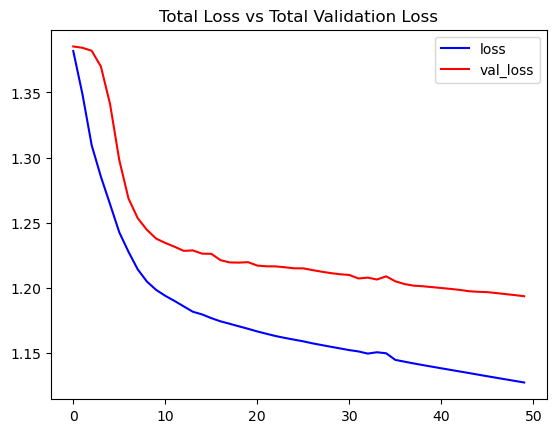

In [39]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

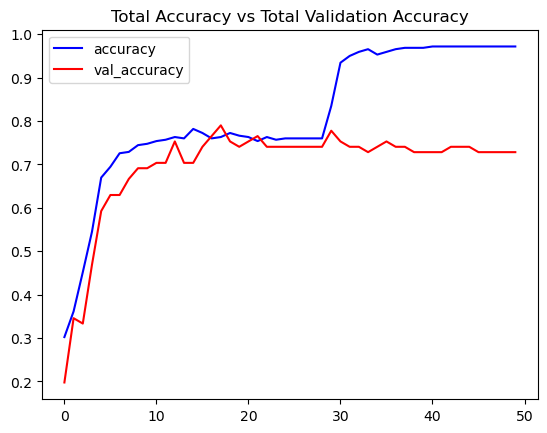

In [40]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')